In [181]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [182]:

##============== bring in data
server = ("Driver={ODBC Driver 17 for SQL Server};"
            "Server=AACTASTPDDBVM01;"
            "Trusted_Connection=yes;")
cnxn = pyodbc.connect(server)

sql = f'''SELECT *
          FROM [Accountability].[dbo].[GradRate]
          WHERE CohortYear between 2018 and 2022'''
gradrate = pd.read_sql(sql , cnxn)

#close connection
cnxn.close()

#col rename
renamed_cols = {'GradRate':'GradRate'
                ,'EntityId':'EntityID'
                ,'NumCohort':'NumCohort'
                ,'GradRateType':'RateType'
                ,'CohortYear':'Cohort'
               ,'Type':'SubGroup'}
gradrate.rename(renamed_cols, inplace=True, axis=1)
## keep relevant subgroups only
db_subgroups = ['SPED','Foster Care','Low SES','ELL Fep','Homeless', "All"]
gradrate = gradrate[(gradrate.SubGroup.isin(db_subgroups)) & (gradrate.EntityID==0)]
##establish a graduating year col
gradrate['GradYear'] = gradrate.Cohort + gradrate.RateType - 4

In [183]:
## keep relevant cols only
cols_to_keep = ['GradYear','EntityID', 'Cohort', 'SubGroup', 'NumCohort',
       'NumGraduates', 'RateType', 'GradRate']
gr = gradrate[cols_to_keep].copy()

#Only keep 2020-2022 Grad years
gr = gr [(gr.GradYear.between(2019,2022)) & (gr.Cohort.between(2018,2022))].copy()

In [184]:
#pivot data to calculate number of graduates from year to year
index=['Cohort', 'SubGroup']
values='NumGraduates'
columns = 'GradYear'

gr_wide = pd.pivot(gr, index=index, columns=columns, values=values)
gr_wide.columns = ['GradYear'+str(i) for i in gr_wide.columns]
##fill empty col with 0 to be able to make computations
gr_wide = gr_wide.fillna(0).reset_index().copy()

In [185]:
gr_wide

,Cohort,SubGroup,GradYear2019,GradYear2020,GradYear2021,GradYear2022
0,2018,All,70642.0,71691.0,72171.0,72434.0
1,2018,ELL Fep,2349.0,2396.0,2411.0,2415.0
2,2018,Foster Care,0.0,8.0,10.0,10.0
3,2018,Homeless,989.0,1013.0,1023.0,1026.0
4,2018,Low SES,24082.0,24524.0,24697.0,24787.0
5,2018,SPED,6398.0,6659.0,6792.0,6858.0
6,2019,All,68388.0,71452.0,72416.0,72952.0
7,2019,ELL Fep,2608.0,2854.0,2894.0,2916.0
8,2019,Foster Care,2.0,20.0,33.0,36.0
9,2019,Homeless,795.0,920.0,944.0,964.0


In [186]:
name = 'GradCount'
gr_wide [name+'2020'] = gr_wide.GradYear2020 - gr_wide.GradYear2019
gr_wide [name+'2021'] = gr_wide.GradYear2021 - gr_wide.GradYear2020
gr_wide [name+'2022'] = gr_wide.GradYear2022 - gr_wide.GradYear2021

##remove meaningless data
gr_wide.loc[gr_wide.Cohort==2021, 'GradCount2020']=np.nan

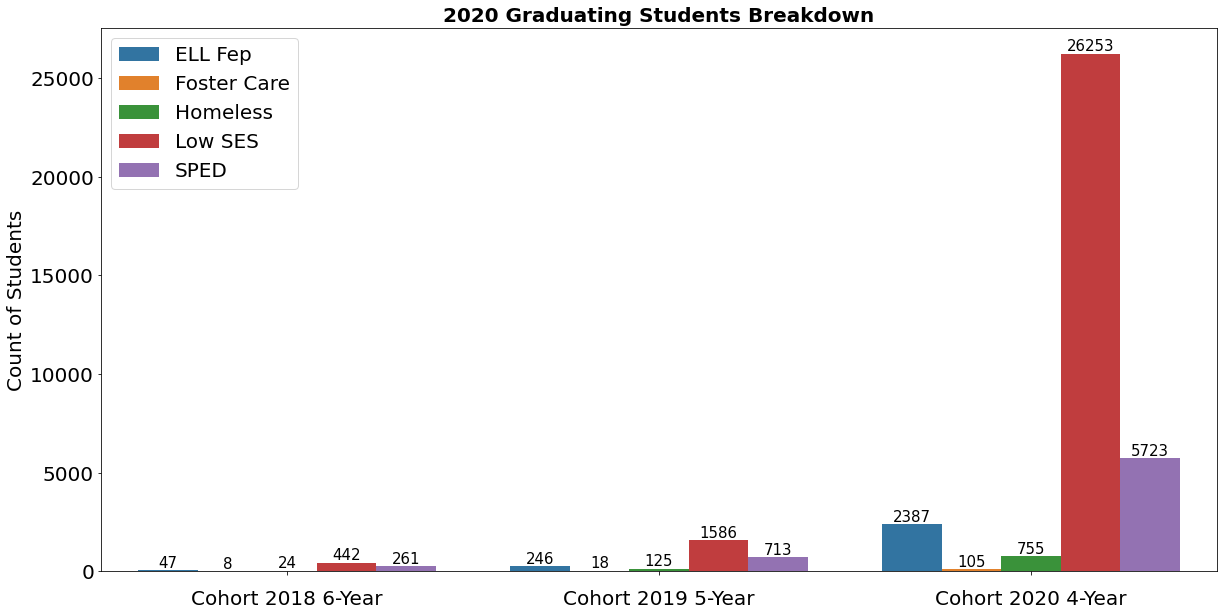

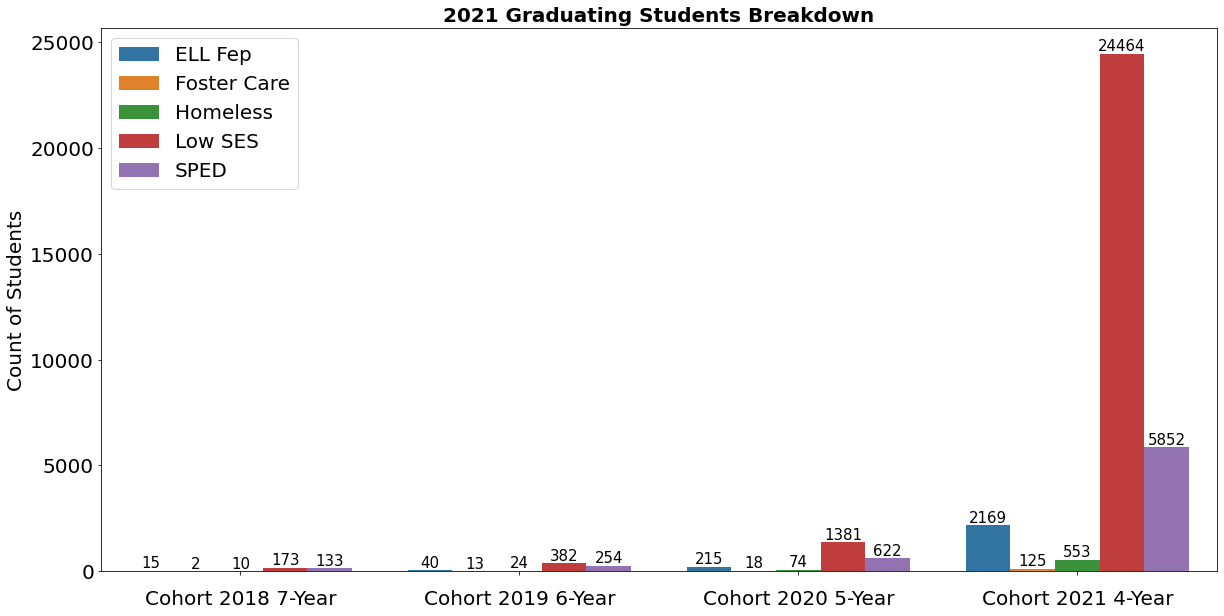

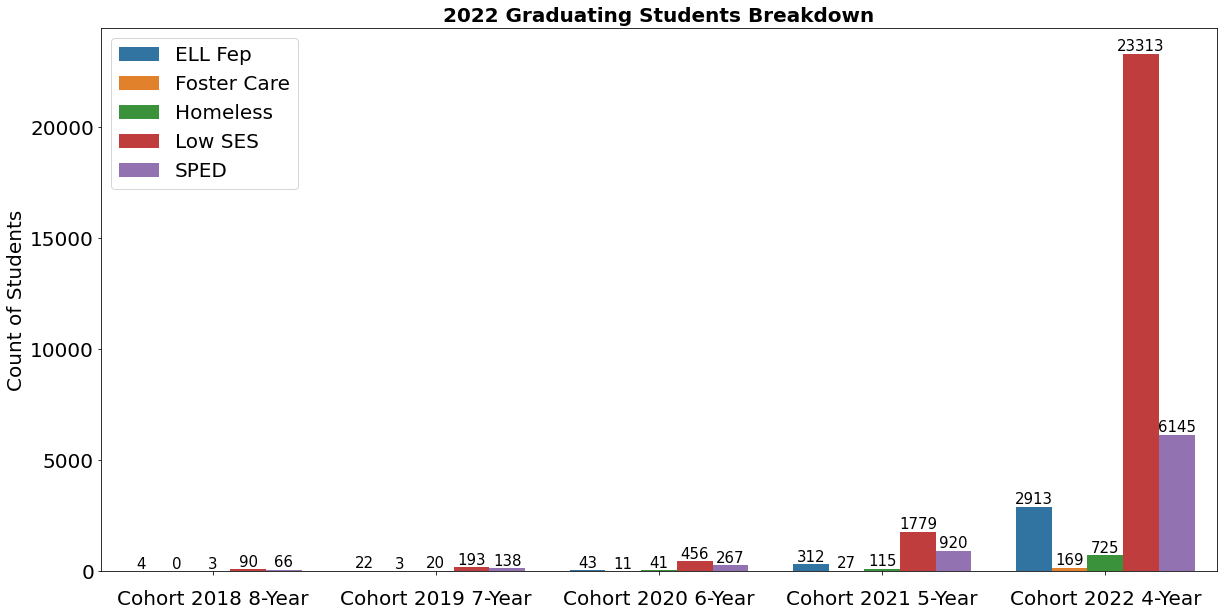

In [187]:
for grad_year in range(2020,2023):
    plt.figure(figsize=(20,10))
    y = 'GradCount'+str(grad_year)
    temp = gr_wide[(gr_wide.Cohort <= grad_year) & (gr_wide.SubGroup!='All')]
    ax=sns.barplot(x=temp.Cohort, y=temp[y], hue=temp.SubGroup)
    for i in np.arange(5):
        ax.bar_label(ax.containers[i], fontsize=15)
    plt.title(str(grad_year)+' Graduating Students Breakdown', fontsize=20, weight='bold')
    plt.xticks(range(len(temp.Cohort.unique())),  ['Cohort '+str(i)+' '+str(grad_year-i+4)+'-Year' for i in range(2018, grad_year+1)], fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Count of Students', fontsize=20)
    plt.xlabel('')
    plt.legend(fontsize=20)
    ax.tick_params(axis='x', which='major', pad=15)

In [190]:
gr_total = gr_wide.groupby('SubGroup').agg(GradCount2020=('GradCount2020', 'sum')
                                           ,GradCount2021=('GradCount2021', 'sum')
                                           ,GradCount2022=('GradCount2022', 'sum')).reset_index()


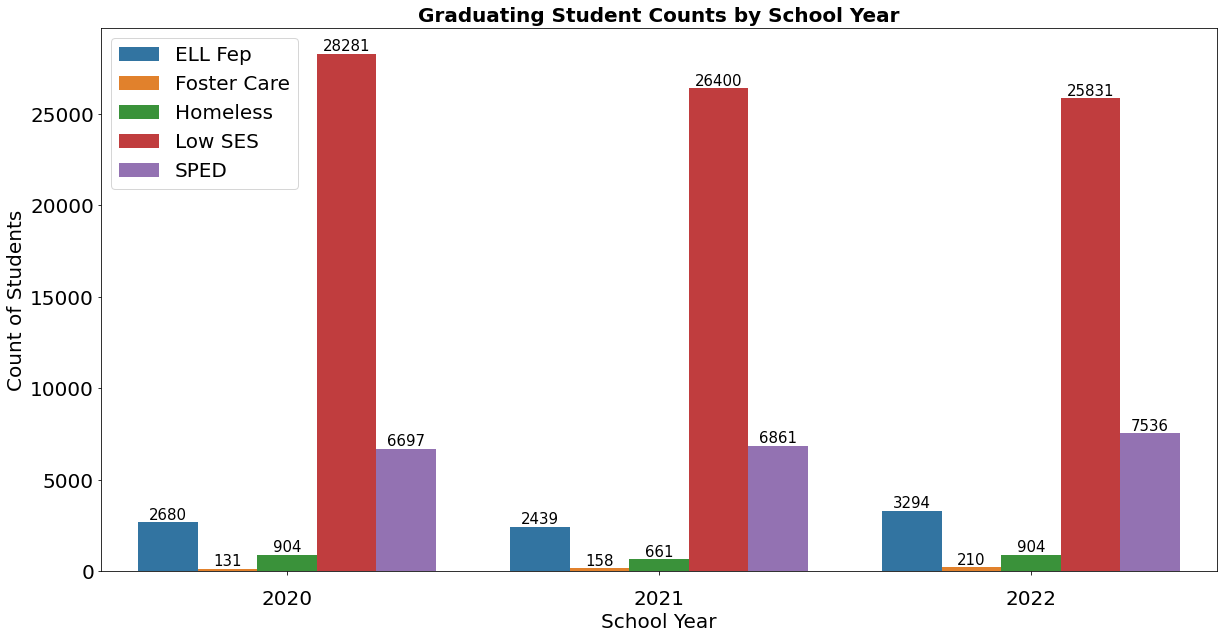

In [208]:
temp = gr_long[gr_long.SubGroup!='All']
plt.figure(figsize=(20,10))
ax=sns.barplot( y=temp.value, x=temp.Grad_Year, hue=temp.SubGroup)
for i in np.arange(5):
    ax.bar_label(ax.containers[i], fontsize=15)
plt.title('Graduating Student Counts by School Year', fontsize=20, weight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Count of Students', fontsize=20)
plt.xlabel('School Year', fontsize=20)
plt.legend(fontsize=20)
ax.tick_params(axis='x', which='major', pad=15)

# We want to find out: 
* what the 4 year graduates demographics look like
* the 5 year
* the 6 year
* and the 7 year

the data is in long format now, with an entry for each subgroup. We group by Cohort Year (since we removed all the other GradRate-Type for each cohort year and the only ones left are the ones graduating in 2021)


In [48]:

##prepare a dataset to be used for grad rate analysis
gr = pd.DataFrame()
for gradratetype, cohort in gradrate_type_map.items():
    temp = gradrate.query(f'RateType=={gradratetype} & Cohort=={cohort} & SubGroup in {db_subgroups}')
    #add data to dataframe
    gr = pd.concat([gr,temp], axis=0) 
    
#only keep the state totals
gr_state = gr[gr.EntityID==0].copy()

# make a column for rate type and cohort
gr_state['CohortRate'] = 'Cohort '+ gr_state.Cohort.astype(str) +' '+ gr_state.RateType.astype(str) + '-year'

In [50]:
gr_state[gr_state.Cohort==2020].head()

,GradRateKey,EntityID,Cohort,SubGroup,NumCohort,NumGraduates,RateType,GradRate,IsFiveYear,CreatedBy,CreatedDate,LastModifiedBy,LastModifiedDate,UploadDate,CohortRate
338542,171A7CFA-A7E3-4FE6-8A88-AA9692997588,0,2020,All,87912,68929,5,78.41,True,Accountability Refresh,2022-07-31 20:01:15.690,Accountability Refresh,2022-07-31 20:01:15.690,2023-04-04 16:51:47.650,Cohort 2020 5-year
338550,27932D4C-7879-4959-A3DB-D849511A1C96,0,2020,SPED,8563,6197,5,72.37,True,Accountability Refresh,2022-07-31 20:01:15.690,Accountability Refresh,2022-07-31 20:01:15.690,2023-04-04 16:51:47.650,Cohort 2020 5-year
338554,0FD3F54D-7C6D-471C-B82E-9550552622BA,0,2020,ELL Fep,3731,2555,5,68.48,True,Accountability Refresh,2022-07-31 20:01:15.690,Accountability Refresh,2022-07-31 20:01:15.690,2023-04-04 16:51:47.650,Cohort 2020 5-year
338555,4C196A45-29D6-4D86-8F76-250C964C6173,0,2020,Low SES,35011,26937,5,76.94,True,Accountability Refresh,2022-07-31 20:01:15.690,Accountability Refresh,2022-07-31 20:01:15.690,2023-04-04 16:51:47.650,Cohort 2020 5-year
338559,3615147C-922A-4410-8B15-89CE0A6C8183,0,2020,Homeless,1371,816,5,59.52,True,Accountability Refresh,2022-07-31 20:01:15.690,Accountability Refresh,2022-07-31 20:01:15.690,2023-04-04 16:51:47.650,Cohort 2020 5-year


<AxesSubplot:xlabel='CohortRate', ylabel='NumGraduates'>

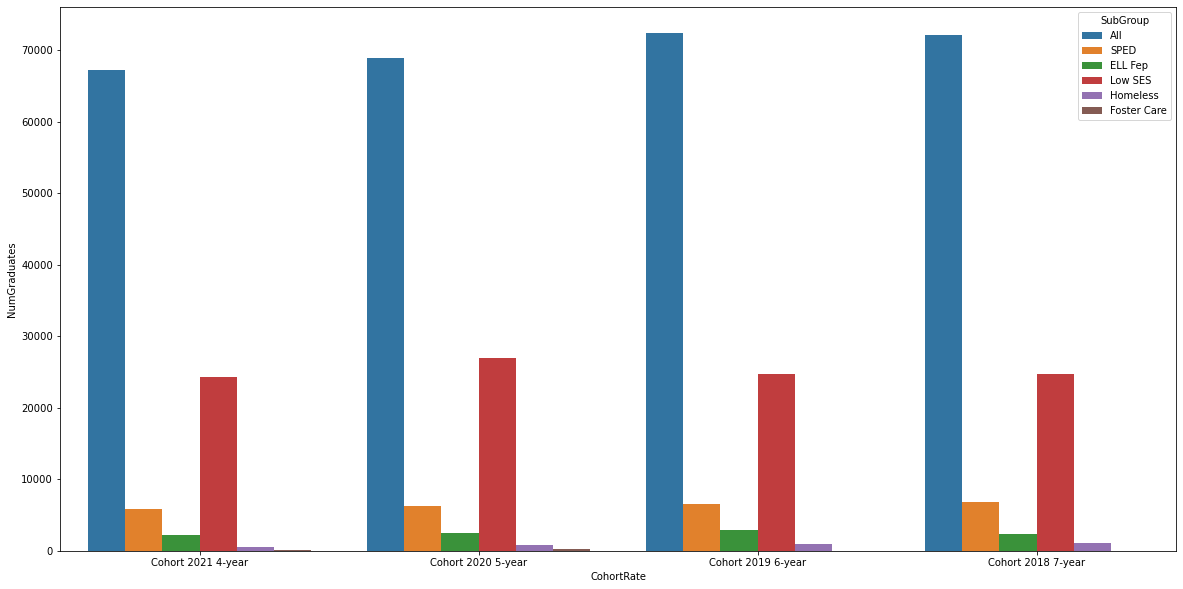

In [51]:
plt.figure(figsize=(20,10))
sns.barplot(x=gr_state.CohortRate, y=gr_state.NumGraduates, hue=gr_state.SubGroup)